In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

# Define functions

## Function to select date range

In [2]:
def get_date_range():
    start_yyyy = int(np.random.uniform(low=2000,high=2020))
    end_yyyy = int(np.random.uniform(low=start_yyyy,high=2020))
    start_yyyy, end_yyyy

    start_date = str(start_yyyy) + '-01-01'
    end_date = str(end_yyyy) + '-12-31'
    
    return start_date, end_date

## Function to pull daily closes from Y-Finance

In [3]:
def get_close_price_df(yf_ticker):
    # generate dates randomly
    start_date, end_date = get_date_range()

    data = yf.download(yf_ticker, start=start_date, end=end_date, progress=False, interval='1d')

    # follow the nomenclature of Yahoo Webscope outlier datasets
    data.rename(columns={'Close':'value'}, inplace=True)
    data['timestamp'] = [int(x.timestamp()) for x in data.index.to_pydatetime()]
    
    data.reset_index(drop=True, inplace=True)
    data = data.filter(['timestamp', 'value'])
    
    return data

## Function to generate random outliers

In [4]:
def generate_outlier_df(df):
    data_size = len(df)

    # randomly decide the number of outliers (b/w 1% to 3%)
    num_outlier = int(np.random.uniform(low=0.01, high=0.03) * data_size)

    # let's set the outlier std to be 10 times the average daily change in price
    avg_price_change = df['value'].diff().abs().mean()

    data_size, num_outlier, avg_price_change

    # define dataframe to store outlier values and locations
    outlier_df = pd.DataFrame()

    # generate list of magnitudes of outlier price changes
    outlier_magnitude_list = np.random.normal(size=num_outlier, loc=10 * avg_price_change, scale=avg_price_change)
    outlier_sign_list = np.random.choice([-1, 1], size=num_outlier)
    outlier_df['value'] = outlier_magnitude_list * outlier_sign_list

    # randomly chose the place where we want to put the outliers
    outlier_df['location'] = [int(x) for x in np.random.uniform(size=num_outlier) * data_size]
    
    return outlier_df

## Function to add outliers to existing data

In [5]:
def add_random_outliers(df):
    # mark current points as normal
    df['is_anomaly'] = 0
    
    # generate df of outliers
    outlier_df = generate_outlier_df(df)

    # add outliers to the original data
    for _, row in outlier_df.iterrows():
        df.at[row['location'], 'value'] += row['value']
        df.at[row['location'], 'is_anomaly'] = 1
    
    return df

## Combined function to pull data and generate outliers

In [6]:
def generate_labeled_outlier_df(yf_ticker):
    # pull data from yfinance
    df = get_close_price_df(yf_ticker)
    
    # add random outliers
    df = add_random_outliers(df)
    
    return df

## Function to plot data and anomalies

In [7]:
def plot(df):
    plt.plot(df['value']);

    if 'is_anomaly' in df.columns:
        plt.scatter(df[df['is_anomaly'] == True].index, df[df['is_anomaly'] == True]['value'], color='red')
    
    plt.tight_layout()
    plt.show()

# Sample output

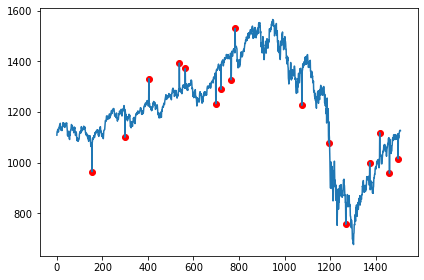

In [8]:
# with outliers
df = generate_labeled_outlier_df('^GSPC')
plot(df)

# Now run for 10 securities and save csv files

In [9]:
# csv files will be saved here
folder_name = 'synthetic-labeled-data'

In [10]:
securities = ['^GSPC', 'MSFT', 'AAPL', 'GS', 'T', 'KO', 'GE', 'MA', 'NKE', 'MMM']
for s in securities:
    df = generate_labeled_outlier_df(s)
    df.to_csv(folder_name + '/' + s.lower() + '.csv', index=False)